# Visualization of inference process

In [1]:
import sys
import torch

import numpy as np

sys.path.append('..')
from utils.model import getModel
from utils.dataset import build_data
from utils.tool import getConfig, extractPDB, Embed
import utils.visualize as vis

/home/perseids/anaconda3/envs/pytorch221/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load components

In [2]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# load embedder
embedder = Embed('Rostlab/prot_t5_xl_uniref50', device)

# Load model
cfg = getConfig('./../config/default.yaml')
cfg['basic']['num_features'] = embedder.featureLen

# set return_attention to True to return attention weights of attention heads
model = getModel(cfg, ckpt='./../checkpoint/SpatialPPIv2_ProtT5.ckpt', return_attention=True).to(device) 
model = model.eval()

Initializing protein sequence embedder ... 

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Seed set to 2032


Done


## Ground truth protein complex P33895-P40460

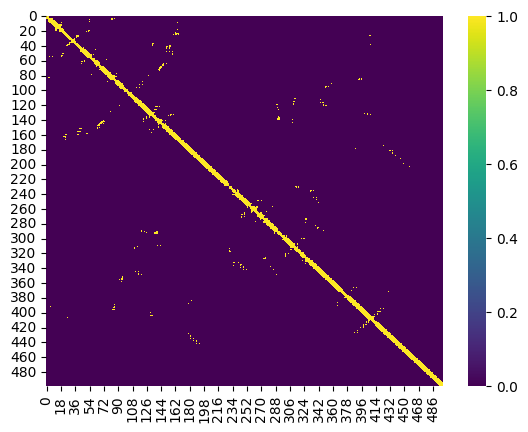

In [5]:
seq_gt, coord_gt = extractPDB('./../demo/P33895-P40460-gt.pdb', chains=['L', 'R'])
vis.visualize_contact_map(np.concatenate(coord_gt), distance_threshold=8)

## Input data of network

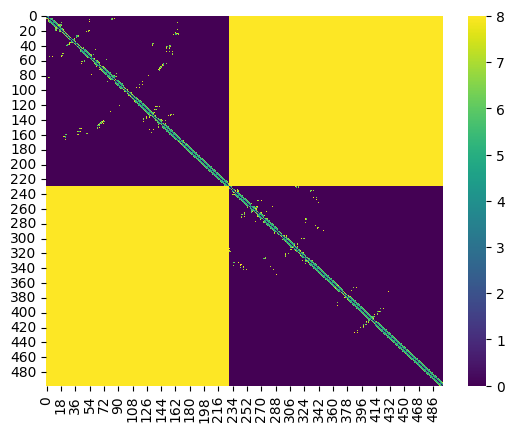

In [6]:
# Load structure from PDB
seq_a, coord_a = extractPDB('./../demo/P33895-P40460-gt.pdb', chains='L')      # Protein P33895
seq_b, coord_b = extractPDB('./../demo/P33895-P40460-gt.pdb', chains='R')      # Protein P40460

# build input data for the network
input_data = build_data(
    node_feature=torch.cat([embedder.encode(i) for i in [seq_a, seq_b]]), 
    coords=[coord_a, coord_b], 
)
vis.visualize_data(input_data)

## Inference input data

In [7]:
with torch.no_grad():
    pred, aws = model(input_data.clone().to(device))
print('Predicted prob:', pred.cpu().tolist()[0])

Predicted prob: 0.9602065086364746


## Visualize attention weights

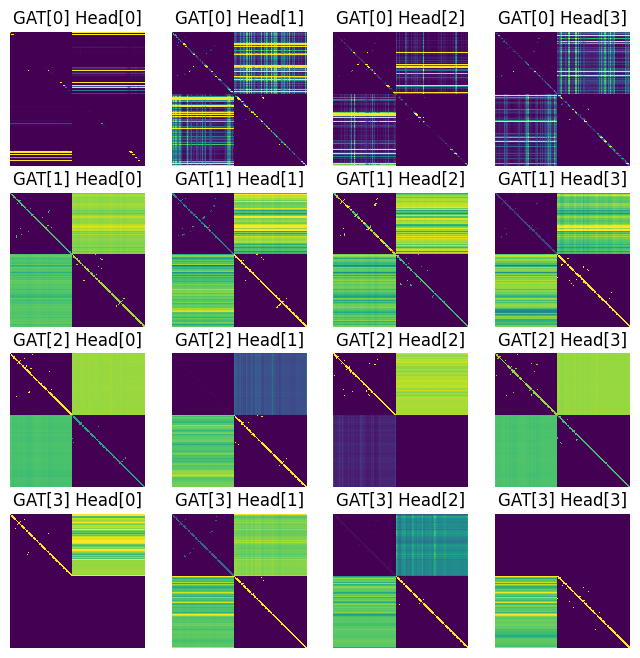

In [8]:
vis.visualize_attentions(input_data, aws, vmin=0, vmax=0.005)